# Instacart Market Basket Analysis

<h1>1.Business/Real-world Problem</h1>

<p>Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.
    
Instacart’s data science team plays a big part in providing this delightful shopping experience. Currently they use transactional data to develop models that predict which products a user will buy again, try for the first time, or add to their cart next during a session.We need to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. </p> <br>
<b>Source: </b>https://www.kaggle.com/c/instacart-market-basket-analysis/overview

<h2> Real-world/Business objectives and constraints.

Objectives:
<ul>
 <li>We need to predict which previously purchased product will be in user's next order</li>
<li> Minimize mean F1 score.</li></ul>
<pre>Constraints:
1. Some form of interpretability
2. No strict latency constraints.

<h1>  Data Overview

The dataset for this competition is a relational set of files describing customers' orders over time. The goal is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

<b>aisles.csv</b><br>
 aisle_id,aisle  
 1,prepared soups salads  
 2,specialty cheeses  
 3,energy granola bars  
 ...<br>
<b> departments.csv</b><br>
 department_id,department  
 1,frozen  
 2,other  
 3,bakery  
 ...<br>
<b> order_products__*.csv</b><br>
These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.

 order_id,product_id,add_to_cart_order,reordered  
 1,49302,1,1  
 1,11109,2,1  
 1,10246,3,0  
 ... <br>
 <b>orders.csv</b><br>
This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

 order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order  
 2539329,1,prior,1,2,08,  
 2398795,1,prior,2,3,07,15.0  
 473747,1,prior,3,3,12,21.0  
 ...<br>
<b> products.csv</b><br>
 product_id,product_name,aisle_id,department_id
 1,Chocolate Sandwich Cookies,61,19  
 2,All-Seasons Salt,104,13  
 3,Robust Golden Unsweetened Oolong Tea,94,7  
 ...<br>
 <b>Source: </b>https://www.kaggle.com/c/instacart-market-basket-analysis/overview

<h2> Mapping the real world problem to a Machine Learning Problem

<h3> Type of Machine Learning Problem 

<pre>
Given a user and order number we need to predict which products he/she will order next
We can also pose this as a Time-series Forecasting and binary classification <br>problem since we have label named reordered which takes value of 0/1.<br>We are calling this as time series forecasting since for each user we have products ordered and order number<br>which shows user's purchase behavior over time.<br>We can use prior dataset to capture user X product behavior over time and <br>create features related to that using aggregation functions.</pre>


<h3>Performance metric

<ul>
<li> Mean F1 score : <b>Source: </b>https://www.kaggle.com/c/instacart-market-basket-analysis/overview</li>
<li> Confusion matrix : https://en.wikipedia.org/wiki/Confusion_matrix</li>  

<h1> Exploratory Data Analysis

<h2> Preprocessing

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from wordcloud import WordCloud
!pip install --upgrade plotly
import plotly.express as px
import gc
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', 100)
import lightgbm as lgb
from sklearn.metrics import f1_score,log_loss
!pip install hpsklearn
from hpsklearn import HyperoptEstimator
from hyperopt import tpe,hp,Trials,fmin,STATUS_OK
import csv
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# import warnings
# warnings.filterwarnings('ignore')

Requirement already up-to-date: plotly in /opt/conda/lib/python3.7/site-packages (4.14.1)
WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [3]:
# Mounting to google drive so that we can use GDrive to read and store the data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.chdir('/content/gdrive/My Drive/uploaded files/Instakart')

function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,6000000)

In [ ]:
# Read the file and see the class distributions and columns present
df_prior = pd.read_csv("order_products__prior.csv")
print(df_prior.head(3),"\n")
print("Class Distribution\n",df_prior['reordered'].value_counts(),"\n")
df_prior.info()

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0 

Class Distribution
 1    19126536
0    13307953
Name: reordered, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [18]:
# Read the file and see the class distributions and columns present
df_train = pd.read_csv("order_products__train.csv")
print(df_train.head(3),"\n")
print("Class Distribution\n",df_train['reordered'].value_counts(),"\n")
df_train.info()

   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0 

Class Distribution
 1    828824
0    555793
Name: reordered, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [ ]:
# Read the file and see the class distributions and columns present
df_orders = pd.read_csv("orders.csv")
print(df_orders.head(3),"\n")
df_orders.info()

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [ ]:
# Read the file and see the class distributions and columns present
df_products = pd.read_csv("products.csv")
print(df_products.head(3),"\n")
df_products.info()

   product_id                          product_name  aisle_id  department_id
0           1            Chocolate Sandwich Cookies        61             19
1           2                      All-Seasons Salt       104             13
2           3  Robust Golden Unsweetened Oolong Tea        94              7 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
# Read the file and see the class distributions and columns present
df_aisles = pd.read_csv("aisles.csv")
print(df_aisles.head(3),"\n")
#print("aisle Distribution\n",df_aisles['aisle'].value_counts(),"\n")
df_aisles.info()

   aisle_id                  aisle
0         1  prepared soups salads
1         2      specialty cheeses
2         3    energy granola bars 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [ ]:
# Read the file and see the class distributions and columns present
df_departments = pd.read_csv("departments.csv")
print(df_departments.head(3),"\n")
#print("departments Distribution\n",df_departments['department'].value_counts(),"\n")
df_departments.info()

   department_id department
0              1     frozen
1              2      other
2              3     bakery 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


We are combing the different dataframes so that all info can be found in one dataframe itself

In [ ]:
df_train_orders = pd.merge(df_train,df_orders,on='order_id')
#df_train_orders.to_pickle("df_train_orders.pkl")

In [ ]:
df_prior_orders = pd.merge(df_prior,df_orders,on='order_id')
#df_prior_orders.to_pickle("df_prior_orders.pkl")

In [ ]:
df_products_aisle_dep = pd.merge(df_products,df_aisles,on = 'aisle_id').merge(df_departments,on='department_id')
# df_products_aisle_dep.to_pickle("df_products_aisle_dep.pkl")

In [ ]:
# df_train_orders = pd.read_pickle("df_train_orders.pkl")
# df_prior_orders = pd.read_pickle("df_prior_orders.pkl")
df_products_aisle_dep = pd.read_pickle("df_products_aisle_dep.pkl")

In [ ]:
# df_prior_final = pd.merge(df_prior_orders,df_products_aisle_dep,on = 'product_id')
# df_train_final = pd.merge(df_train_orders,df_products_aisle_dep,on = 'product_id')
# df_prior_final.to_csv('df_prior_final.csv',index=False)
# df_train_final.to_csv('df_train_final.csv',index=False)
##Reading the merged file
df_prior_final=  pd.read_csv('df_prior_final.csv')
df_train_final = pd.read_csv('df_train_final.csv')

In [ ]:
df_prior_train

In [ ]:
df_prior_final

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3265099,43492,3,0,111311,prior,2,3,10,5.0,Gourmet Burger Seasoning,104,13,spices seasonings,pantry
32434485,3361945,43492,19,0,142932,prior,25,3,10,5.0,Gourmet Burger Seasoning,104,13,spices seasonings,pantry
32434486,3267201,33097,2,0,183867,prior,19,3,18,3.0,Piquillo & Jalapeno Bruschetta,81,15,canned jarred vegetables,canned goods
32434487,3393151,38977,32,0,79056,prior,1,4,13,NaN,Original Jerky,100,21,missing,missing


<h3> Checking for NaN values 



In [ ]:
print("No of Nan values in our dataframe : ", sum(df_prior_final.isnull().any(axis=1)))
print("Columns that contains Nan values : ", df_prior_final.columns[df_prior_final.isnull().any(axis=0)].values)

No of Nan values in our dataframe :  2078068
columns that contains Nan values :  ['days_since_prior_order']


Let us further investigate the NaN rows

In [ ]:
df_prior_final[df_prior_final.isnull().any(axis=1)].head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
39,5733,33120,8,0,92179,prior,1,6,10,NaN,Organic Egg Whites,86,16,eggs,dairy eggs
53,8762,33120,4,0,68183,prior,1,3,8,NaN,Organic Egg Whites,86,16,eggs,dairy eggs
56,9081,33120,1,0,124123,prior,1,1,15,NaN,Organic Egg Whites,86,16,eggs,dairy eggs
89,15180,33120,3,0,188560,prior,1,6,7,NaN,Organic Egg Whites,86,16,eggs,dairy eggs
94,16391,33120,4,0,67433,prior,1,0,18,NaN,Organic Egg Whites,86,16,eggs,dairy eggs


One observation is that all above NaN rows has order_number as 1. Let us recheck that

In [ ]:
df_prior_final[df_prior_final.isnull().any(axis=1)]['order_number'].value_counts()

1    2078068
Name: order_number, dtype: int64

<b>Observation :</b> Only days_since_prior_order column contains NaN values. It may be due to people placing their first product as from the above analysis we can see that for all such NaN rows of 'days_since_prior_order' we have order_number as 1. And this also makes sense that people placing their first order doesn't have any order history.

<h3> Removing Duplicates 

In [ ]:
dups = sum(df_prior_final.duplicated(['order_id','user_id','product_id']))
print("There are {} duplicate entries in the data..".format(dups))

There are 0 duplicate entries in the data..


<h3>  Basic Statistics

In [ ]:
print("Total unique data points : {0}".format(df_orders.shape[0]))
print("-"*50)
print("Total unique data points in prior set : {0}".format(df_orders[df_orders['eval_set']=='prior'].shape[0]))
print("-"*50)
print("Total unique data points in train set : {0}".format(df_orders[df_orders['eval_set']=='train'].shape[0]))
print("-"*50)
print("Total unique data points in test set : {0}".format(df_orders[df_orders['eval_set']=='test'].shape[0]))
print("-"*50)
print("Total No of Users   :", len(np.unique(df_prior_final.user_id)))
print("Total No of Products  :", len(np.unique(df_prior_final.product_id)))

Total unique data points : 3421083
--------------------------------------------------
Total unique data points in prior set : 3214874
--------------------------------------------------
Total unique data points in train set : 131209
--------------------------------------------------
Total unique data points in test set : 75000
--------------------------------------------------
Total No of Users   : 206209
Total No of Products  : 49677


+-----------+---------------+-----------------+
| DataSet   |   Order Count |   % Order Count |
|-----------+---------------+-----------------|
| prior     |       3214874 |            94   |
| train     |        131209 |             3.8 |
| test      |         75000 |             2.2 |
+-----------+---------------+-----------------+ 



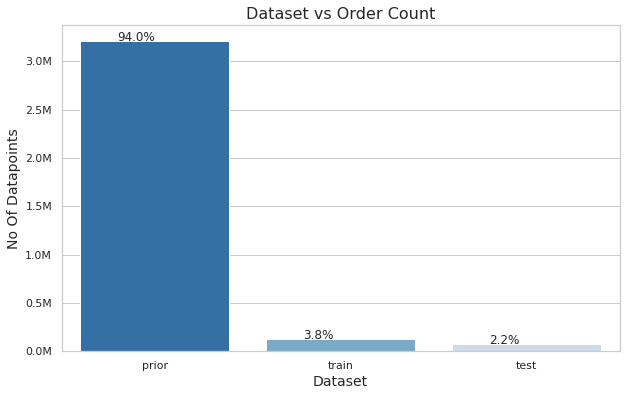

In [ ]:
# Reference :https://stackoverflow.com/questions/53747298/how-to-format-seaborn-matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
eval_set = df_orders['eval_set'].value_counts().sort_values(ascending=False)
eval_set_df = eval_set.to_frame().reset_index().rename(columns={'index':'DataSet','eval_set':'Order Count'})
eval_set_df['% Order Count'] = np.round((eval_set_df['Order Count']/sum(eval_set_df['Order Count'])).values,3)*100
print(tabulate(eval_set_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
ax = sns.barplot(x = eval_set.index,y = eval_set.values,palette='Blues_r')
plt.title("Dataset vs Order Count",size=16)
plt.xlabel('Dataset',size=14)
plt.ylabel('No Of Datapoints',size=14)
total = sum(eval_set_df['Order Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
ylabels = list(map(lambda x : '{:.1f}'.format(x/10**6) + 'M', list(ax.get_yticks())))
ax.set_yticklabels(ylabels)
plt.show()  

<b>Observation :</b> We have lots of data( 3.2 Million ) about users previous purchase history. We need to give predictions on the test set which is 75000 (2.2% of total data points) as mentioned in the problem description.

+---------------+---------------+-----------------+-----------------+-------------------+
|   Day Of Week |   Order Count |   % Order Count |   ReOrder Count |   % ReOrder Count |
|---------------+---------------+-----------------+-----------------+-------------------|
|             0 |        600905 |            17.6 |          494204 |              17.5 |
|             1 |        587478 |            17.2 |          492523 |              17.4 |
|             2 |        467260 |            13.7 |          386578 |              13.7 |
|             5 |        453368 |            13.3 |          374623 |              13.3 |
|             6 |        448761 |            13.1 |          368151 |              13   |
|             3 |        436972 |            12.8 |          359576 |              12.7 |
|             4 |        426339 |            12.5 |          350706 |              12.4 |
+---------------+---------------+-----------------+-----------------+-------------------+ 



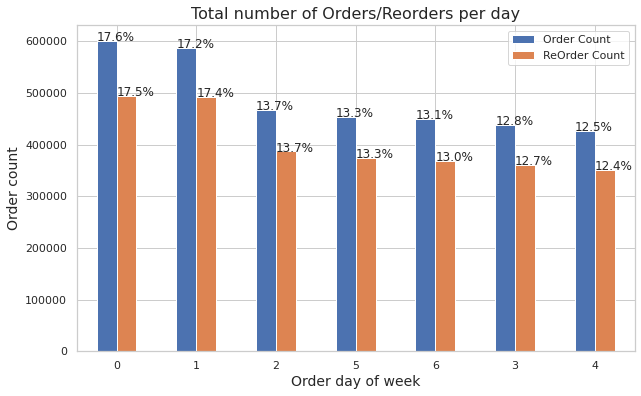

In [ ]:
order_dow = df_orders['order_dow'].value_counts().sort_values(ascending=False)
order_dow_df = order_dow.to_frame().reset_index().rename(columns={'index':'Day Of Week','order_dow':'Order Count'})
order_dow_df['% Order Count'] = np.round((order_dow_df['Order Count']/sum(order_dow_df['Order Count'])).values,3)*100
g = df_prior_final[df_prior_final['reordered']==1].groupby(['order_id','order_dow']).groups.keys()
reorder_dow =  pd.DataFrame(g,columns=['order_id','order_dow'])['order_dow'].value_counts().sort_values(ascending=False).reset_index().\
                                                                                          rename(columns={'index':'Day Of Week','order_dow':'ReOrder Count'})
order_dow_df = pd.merge(order_dow_df,reorder_dow,on='Day Of Week')                                                                                    
order_dow_df['% ReOrder Count'] =  np.round((order_dow_df['ReOrder Count']/sum(order_dow_df['ReOrder Count'])).values,3)*100
print(tabulate(order_dow_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
ax = order_dow_df.set_index('Day Of Week')[['Order Count','ReOrder Count']].plot(kind='bar',figsize=(10,6),rot=0)
plt.title("Total number of Orders/Reorders per day",size=16)
plt.xlabel('Order day of week',size=14)
plt.ylabel('Order count',size=14)
total_order = sum(order_dow_df['Order Count'])
total_reorder = sum(order_dow_df['ReOrder Count'])
for p in ax.patches[:7]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_order),(p.get_x(),p.get_height()+5))
for p in ax.patches[7:]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_reorder),(p.get_x(),p.get_height()+5))
plt.show()  

<b>Observation :</b> People are more likely to place orders on saturday(day 0) and sunday (day 1) than other days. Same trend follows for reorders also.


+---------------+---------------+-----------------+
|   Hour of day |   Order Count |   % Order Count |
|---------------+---------------+-----------------|
|            10 |        288418 |             8.4 |
|            11 |        284728 |             8.3 |
|            15 |        283639 |             8.3 |
|            14 |        283042 |             8.3 |
|            13 |        277999 |             8.1 |
|            12 |        272841 |             8   |
|            16 |        272553 |             8   |
|             9 |        257812 |             7.5 |
|            17 |        228795 |             6.7 |
|            18 |        182912 |             5.3 |
|             8 |        178201 |             5.2 |
|            19 |        140569 |             4.1 |
|            20 |        104292 |             3   |
|             7 |         91868 |             2.7 |
|            21 |         78109 |             2.3 |
|            22 |         61468 |             1.8 |
|           

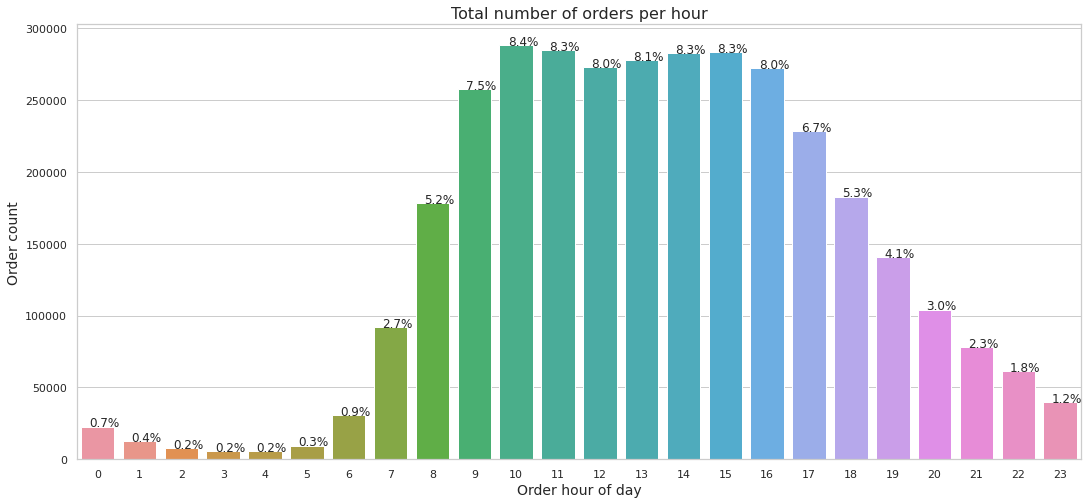

In [ ]:
order_hour_of_day = df_orders.fillna(0)['order_hour_of_day'].value_counts().sort_values(ascending=False)
order_hour_of_day_df = order_hour_of_day.to_frame().reset_index().rename(columns={'index':'Hour of day','order_hour_of_day':'Order Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
order_hour_of_day_df['% Order Count'] = np.round((order_hour_of_day_df['Order Count']/sum(order_hour_of_day_df['Order Count'])).values,3)*100
print(tabulate(order_hour_of_day_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x = order_hour_of_day.index,y = order_hour_of_day.values)
plt.title("Total number of orders per hour",size=16)
plt.xlabel('Order hour of day',size=14)
plt.ylabel('Order count',size=14)
total = sum(order_hour_of_day_df['Order Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
plt.show()  

<b>Observation :</b> Most people buy products between 7 AM to 8 PM. 10 AM is the peak hour when highest order is received.

+---------------+-----------------+-------------------+
|   Hour of day |   ReOrder Count |   % ReOrder Count |
|---------------+-----------------+-------------------|
|            10 |          239805 |               8.5 |
|            11 |          235078 |               8.3 |
|            15 |          233096 |               8.2 |
|            14 |          232858 |               8.2 |
|            13 |          228950 |               8.1 |
|            12 |          224027 |               7.9 |
|            16 |          223892 |               7.9 |
|             9 |          216067 |               7.6 |
|            17 |          187142 |               6.6 |
|             8 |          150623 |               5.3 |
|            18 |          149470 |               5.3 |
|            19 |          115000 |               4.1 |
|            20 |           85914 |               3   |
|             7 |           78237 |               2.8 |
|            21 |           64915 |             

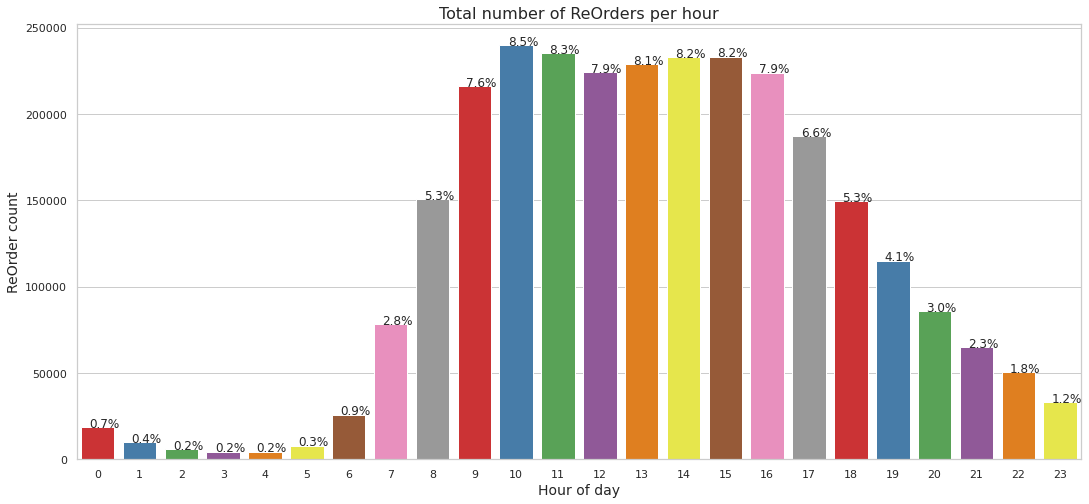

In [ ]:
#g = df_prior_final[df_prior_final['reordered']==1].groupby(['order_id','order_hour_of_day']).groups.keys()
reorder_hour_of_day_df  =  pd.DataFrame(g,columns=['order_id','order_hour_of_day'])['order_hour_of_day'].value_counts().sort_values(ascending=False)\
                                                                                  .reset_index().rename(columns={'index':'Hour of day','order_hour_of_day':'ReOrder Count'})
reorder_hour_of_day_df['% ReOrder Count'] =  np.round((reorder_hour_of_day_df['ReOrder Count']/sum(reorder_hour_of_day_df['ReOrder Count'])).values,3)*100
print(tabulate(reorder_hour_of_day_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x = reorder_hour_of_day_df['Hour of day'],y = reorder_hour_of_day_df['ReOrder Count'],palette='Set1')
plt.title("Total number of ReOrders per hour",size=16)
plt.xlabel('Hour of day',size=14)
plt.ylabel('ReOrder count',size=14)
total = sum(reorder_hour_of_day_df['ReOrder Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
plt.show()  

<b>Observation :</b> Most people Reorder products between 7 AM to 8 PM. 10 AM is the peak hour when highest Reorder is received.

+--------+---------------+-----------------+
|   days |   Order Count |   % Order Count |
|--------+---------------+-----------------|
|     30 |        369323 |            10.8 |
|      7 |        320608 |             9.4 |
|      0 |        273964 |             8   |
|      6 |        240013 |             7   |
|      4 |        221696 |             6.5 |
|      3 |        217005 |             6.3 |
|      5 |        214503 |             6.3 |
|      2 |        193206 |             5.6 |
|      8 |        181717 |             5.3 |
|      1 |        145247 |             4.2 |
|      9 |        118188 |             3.5 |
|     14 |        100230 |             2.9 |
|     10 |         95186 |             2.8 |
|     13 |         83214 |             2.4 |
|     11 |         80970 |             2.4 |
|     12 |         76146 |             2.2 |
|     15 |         66579 |             1.9 |
|     16 |         46941 |             1.4 |
|     21 |         45470 |             1.3 |
|     17 |

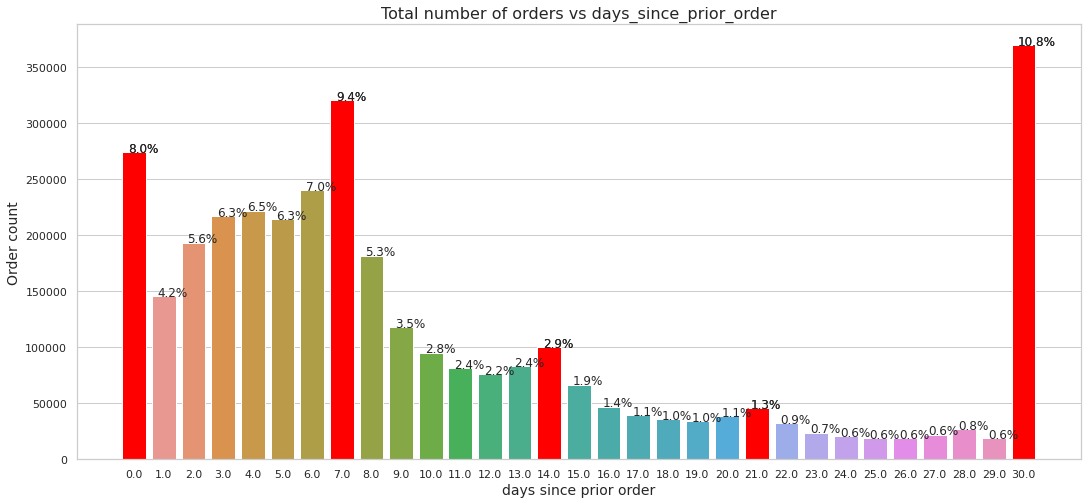

In [ ]:
#filling NaN values with 0 since days_since_prior_order will be 0 for users ordering their first product
days_since_prior_order = df_orders.fillna(0)['days_since_prior_order'].value_counts().sort_values(ascending=False)
days_since_prior_order_df =  days_since_prior_order.to_frame().reset_index().rename(columns={'index':'days','days_since_prior_order':'Order Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
days_since_prior_order_df['% Order Count'] = np.round(( days_since_prior_order_df['Order Count']/sum( days_since_prior_order_df['Order Count'])).values,3)*100
print(tabulate( days_since_prior_order_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x =  days_since_prior_order.index,y =  days_since_prior_order.values)
spikes = [0,7,14,21,30]
plt.bar(x = spikes,height=days_since_prior_order[spikes].values,color='red')
plt.title("Total number of orders vs days_since_prior_order",size=16)
plt.xlabel('days since prior order',size=14)
plt.ylabel('Order count',size=14)
total = sum(days_since_prior_order_df['Order Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
plt.show()  

<b>Observation :</b> Clearly People are likely to reorder products after 7th, 14th,21th,30th day after 0th day as we can clearly see spike at every 7th, 14th,21th,30th wrt its neiborhood days.This also makes sense as plople tend to buy products weekly and monthly basis <br> 30th day is the highest no of orders placed






+--------------------------+-----------------+-------------------+
|   days_since_prior_order |   ReOrder Count |   % ReOrder Count |
|--------------------------+-----------------+-------------------|
|                        7 |          296792 |              10.5 |
|                       30 |          267518 |               9.5 |
|                        6 |          221715 |               7.8 |
|                        4 |          204635 |               7.2 |
|                        3 |          199418 |               7.1 |
|                        5 |          197792 |               7   |
|                        2 |          174781 |               6.2 |
|                        8 |          166744 |               5.9 |
|                        1 |          125922 |               4.5 |
|                        9 |          107318 |               3.8 |
|                       14 |           88752 |               3.1 |
|                       10 |           86085 |               3

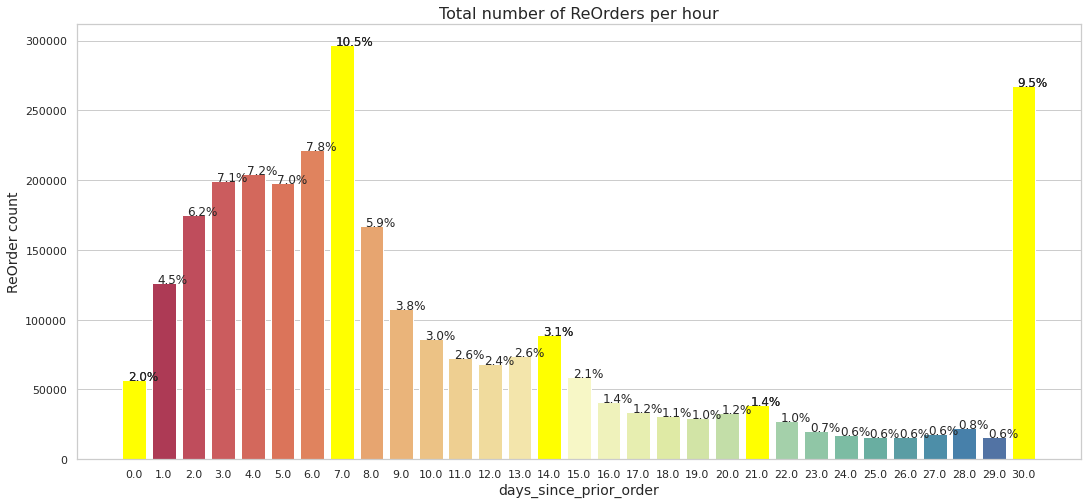

In [ ]:
g = df_prior_final[df_prior_final['reordered']==1].fillna(0).groupby(['order_id','days_since_prior_order']).groups.keys()
reorder_days_since_prior_order_df  =  pd.DataFrame(g,columns=['order_id','days_since_prior_order'])['days_since_prior_order'].value_counts().sort_values(ascending=False)\
                                                              .reset_index().rename(columns={'index':'days_since_prior_order','days_since_prior_order':'ReOrder Count'})
reorder_days_since_prior_order_df['% ReOrder Count'] =  np.round((reorder_days_since_prior_order_df['ReOrder Count']/sum(reorder_days_since_prior_order_df['ReOrder Count'])).values,3)*100
print(tabulate(reorder_days_since_prior_order_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x = reorder_days_since_prior_order_df['days_since_prior_order'],y = reorder_days_since_prior_order_df['ReOrder Count'],palette='Spectral')
spikes = [0,7,14,21,30]
plt.bar(x = spikes,height=reorder_days_since_prior_order_df[reorder_days_since_prior_order_df['days_since_prior_order'].\
                                                            isin(spikes)].sort_values('days_since_prior_order',axis=0)['ReOrder Count'],color='yellow')
plt.title("Total number of ReOrders per hour",size=16)
plt.xlabel('days_since_prior_order',size=14)
plt.ylabel('ReOrder count',size=14)
total = sum(reorder_days_since_prior_order_df['ReOrder Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
plt.show()  

Observation : Similar pattern follows for reorders same as order. Here
7th days_since_prior_order is the highest no of reorders placed

+--------------------+---------------+-----------------+
|   max_order_number |   Order Count |   % Order Count |
|--------------------+---------------+-----------------|
|                  4 |         23986 |          11.632 |
|                  5 |         19590 |           9.5   |
|                  6 |         16165 |           7.839 |
|                  7 |         13850 |           6.716 |
|                  8 |         11700 |           5.674 |
|                  9 |         10190 |           4.942 |
|                 10 |          9032 |           4.38  |
|                 11 |          7815 |           3.79  |
|                 12 |          6952 |           3.371 |
|                 13 |          6236 |           3.024 |
|                 14 |          5613 |           2.722 |
|                 15 |          5191 |           2.517 |
|                 16 |          4593 |           2.227 |
|                 17 |          4139 |           2.007 |
|                 18 |         

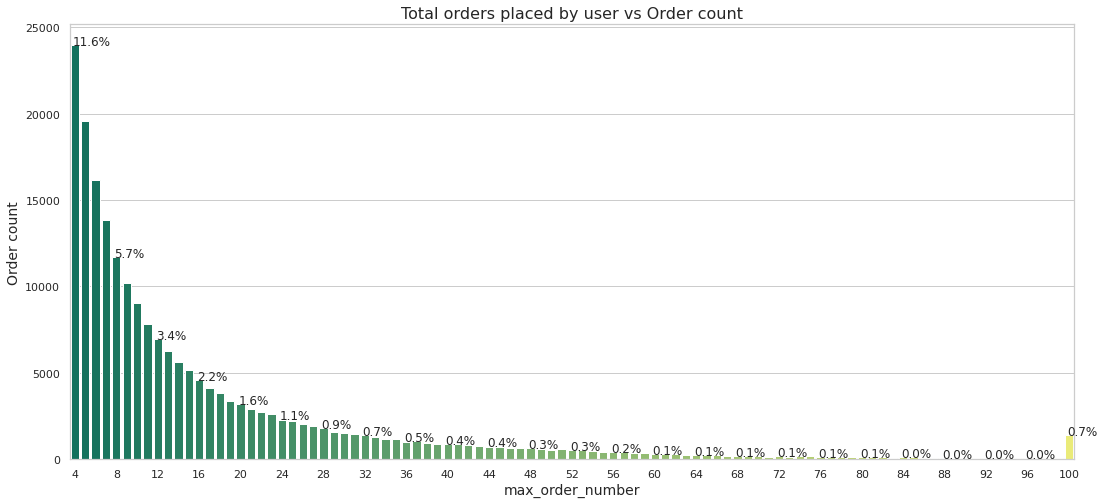

In [ ]:
max_order_number = df_orders.groupby('user_id')['order_number'].agg(np.max).reset_index().rename\
                                                    (columns={'order_number':'max_order_number'})['max_order_number'].value_counts().sort_values(ascending=False)
max_order_number_df =  max_order_number.to_frame().reset_index().rename(columns={'index':'max_order_number','max_order_number':'Order Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
max_order_number_df['% Order Count'] = np.round((  max_order_number_df['Order Count']/sum(  max_order_number_df['Order Count'])).values,5)*100
print(tabulate(  max_order_number_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x =   max_order_number.index,y =   max_order_number.values,palette='summer')
plt.title("Total orders placed by user vs Order count",size=16)
plt.xlabel('max_order_number',size=14)
plt.ylabel('Order count',size=14)
total = sum( max_order_number_df['Order Count'])
i=0
for p in ax.patches:
  if i%4==0:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
  i+=1
locs, labels = plt.xticks()
plt.xticks(locs[::4], labels[::4]) 
#ax.set_xticklabels(labels, rotation=30,horizontalalignment='right')
plt.show()  

<b>Observation :</b> There is no user who has placed less than 4 oders and max order placed by users is 100

+---------------+---------------+-----------------+
|   bucket_size |   Order Count |   % Order Count |
|---------------+---------------+-----------------|
|             5 |        228330 |          7.1023 |
|             6 |        227675 |          7.0819 |
|             4 |        222081 |          6.9079 |
|             7 |        220006 |          6.8434 |
|             3 |        207027 |          6.4397 |
|             8 |        203374 |          6.326  |
|             2 |        186993 |          5.8165 |
|             9 |        184347 |          5.7342 |
|            10 |        165550 |          5.1495 |
|             1 |        156748 |          4.8757 |
|            11 |        147461 |          4.5868 |
|            12 |        131580 |          4.0929 |
|            13 |        116871 |          3.6353 |
|            14 |        103683 |          3.2251 |
|            15 |         91644 |          2.8506 |
|            16 |         81192 |          2.5255 |
|           

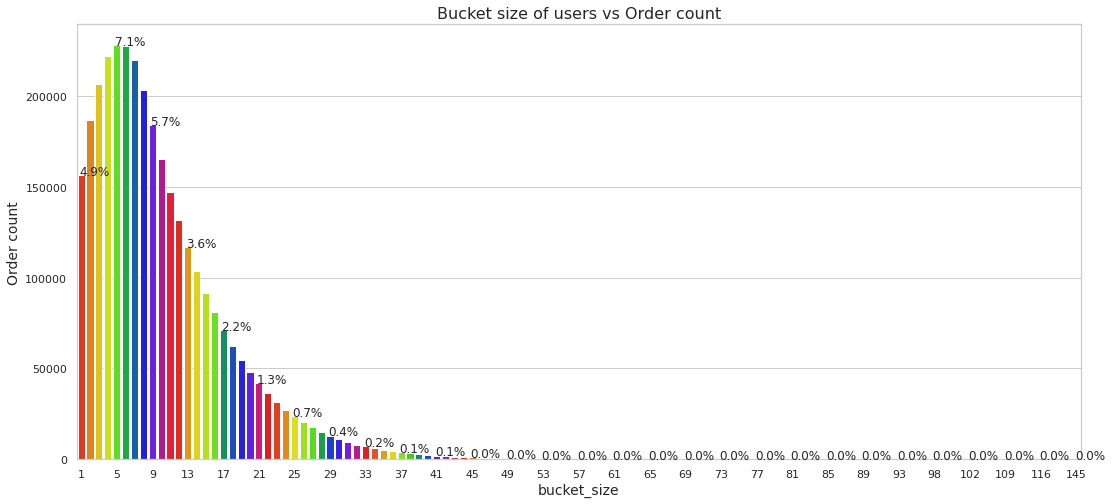

In [ ]:
bucket_size = df_prior_final.groupby('order_id')['add_to_cart_order'].agg(np.max).reset_index().rename\
                                                    (columns={'add_to_cart_order':'bucket_size'})['bucket_size'].value_counts().sort_values(ascending=False)
bucket_size_df = bucket_size.to_frame().reset_index().rename(columns={'index':'bucket_size','bucket_size':'Order Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
bucket_size_df['% Order Count'] = np.round(( bucket_size_df['Order Count']/sum( bucket_size_df['Order Count'])).values,6)*100
print(tabulate( bucket_size_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x =  bucket_size.index,y =  bucket_size.values,palette='prism')
plt.title("Bucket size of users vs Order count",size=16)
plt.xlabel('bucket_size',size=14)
plt.ylabel('Order count',size=14)
total = sum(bucket_size_df['Order Count'])
for p in ax.patches[::4]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
locs, labels = plt.xticks()
plt.xticks(locs[::4], labels[::4]) 
plt.show()                         

<b>Observation :</b> Bucket size of 5 and 6 are most frequent. Highest bucket size is 145 and there is only one user who has bought 145 products in an order

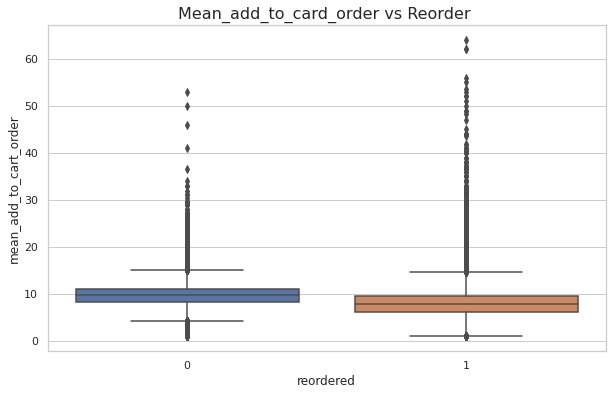

In [ ]:
mean_add_to_cart_order = df_prior_final[['product_id','add_to_cart_order','reordered']].groupby(['product_id','reordered'])['add_to_cart_order'].agg('mean')
mean_add_to_cart_order = mean_add_to_cart_order.reset_index().rename(columns ={'add_to_cart_order':'mean_add_to_cart_order'})
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.boxplot(x='reordered',y='mean_add_to_cart_order',data=mean_add_to_cart_order)
plt.title("Mean_add_to_cart_order vs Reorder ",size=16)
plt.show()

<b>Observation :</b> Products that are not reordered have slightly high add_to_cart_order than products that are reordered. People are likely to put the reordered products in the cart first and they put not reordered products in the cart last.

		Word Cloud of Products Ordered



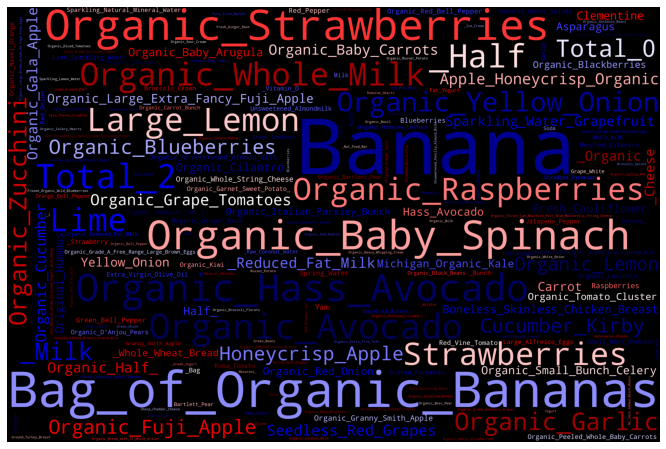


Top 100 products
+----------------------------------------------------------------+-----------------+-------------------+
| Product Name                                                   |   Product Count |   % Product Count |
|----------------------------------------------------------------+-----------------+-------------------|
| Banana                                                         |          472565 |               1.5 |
| Bag of Organic Bananas                                         |          379450 |               1.2 |
| Organic Strawberries                                           |          264683 |               0.8 |
| Organic Baby Spinach                                           |          241921 |               0.7 |
| Organic Hass Avocado                                           |          213584 |               0.7 |
| Organic Avocado                                                |          176815 |               0.5 |
| Large Lemon                        

In [ ]:
# Reference : https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
def plot_cloud(word_cloud):
  '''
    This function plots the world cloud 

    Attributes
    word_cloud : word cloud object

    Returns None
  '''
  plt.figure(figsize=(20,8))
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.show()

products = df_prior_final['product_name'].to_list()
products = list(map(lambda x : '_'.join(str(x).split()),products))
products = ' '.join(products)
print("\t\tWord Cloud of Products Ordered\n")
word_cloud = WordCloud(width = 3000, height = 2000, random_state=1,background_color='black',colormap='seismic',collocations=False).generate(products)
plot_cloud(word_cloud)
print("\nTop 100 products")
product = df_prior_final['product_name'].value_counts().sort_values(ascending=False)
product_df =  product.to_frame().reset_index().rename(columns={'index':'Product Name','product_name':'Product Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
product_df['% Product Count'] = np.round(( product_df['Product Count']/sum( product_df['Product Count'])).values,3)*100
print(tabulate( product_df.head(100), headers='keys',showindex=False,tablefmt="psql"),"\n")

<b>Observation :</b> People are more likely to order orgainc products and fruits spcially organic fruits.Banana is the hishest ordered product.

		Word Cloud of Products ReOrdered



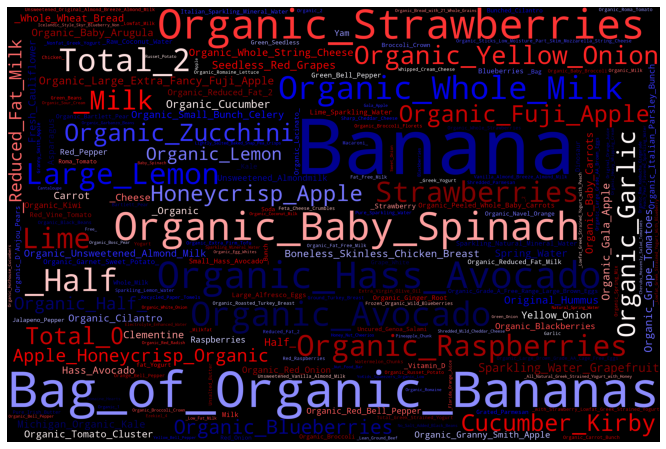


Top 100 ReOrdered products
+----------------------------------------------------------------+-----------------+-------------------+
| Product Name                                                   |   Product Count |   % Product Count |
|----------------------------------------------------------------+-----------------+-------------------|
| Banana                                                         |          398609 |               2.1 |
| Bag of Organic Bananas                                         |          315913 |               1.7 |
| Organic Strawberries                                           |          205845 |               1.1 |
| Organic Baby Spinach                                           |          186884 |               1   |
| Organic Hass Avocado                                           |          170131 |               0.9 |
| Organic Avocado                                                |          134044 |               0.7 |
| Organic Whole Milk       

In [ ]:
# Reference : https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
def plot_cloud(word_cloud):
    '''
    This function plots the world cloud 

    Attributes
    word_cloud : word cloud object

    Returns None
    '''
    plt.figure(figsize=(20,8))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

products = df_prior_final[df_prior_final['reordered']==1]['product_name'].to_list()
products = list(map(lambda x : '_'.join(str(x).split()),products))
products = ' '.join(products)
print("\t\tWord Cloud of Products ReOrdered\n")
word_cloud = WordCloud(width = 3000, height = 2000, random_state=1,background_color='black',colormap='seismic',collocations=False).generate(products)
plot_cloud(word_cloud)
print("\nTop 100 ReOrdered products")
product = df_prior_final[df_prior_final['reordered']==1]['product_name'].value_counts().sort_values(ascending=False)
product_df =  product.to_frame().reset_index().rename(columns={'index':'Product Name','product_name':'Product Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
product_df['% Product Count'] = np.round(( product_df['Product Count']/sum( product_df['Product Count'])).values,3)*100
print(tabulate( product_df.head(100), headers='keys',showindex=False,tablefmt="psql"),"\n")

<b>Observation :</b> People are more likely to Reorder orgainc products and fruits.Banana is the hishest reordered product.

+-------------------+-------------------------+---------------------------+---------------------------+-----------------------------+-----------------+-------------------+
| Department Name   |   Ordered Product Count |   % Ordered Product Count |   ReOrdered Product Count |   % ReOrdered Product Count |   Product Count |   % Product Count |
|-------------------+-------------------------+---------------------------+---------------------------+-----------------------------+-----------------+-------------------|
| produce           |                 9479291 |                      29.2 |                   6160710 |                        32.2 |            1684 |               3.4 |
| dairy eggs        |                 5414016 |                      16.7 |                   3627221 |                        19   |            3449 |               6.9 |
| snacks            |                 2887550 |                       8.9 |                   1657973 |                         8.7 |       

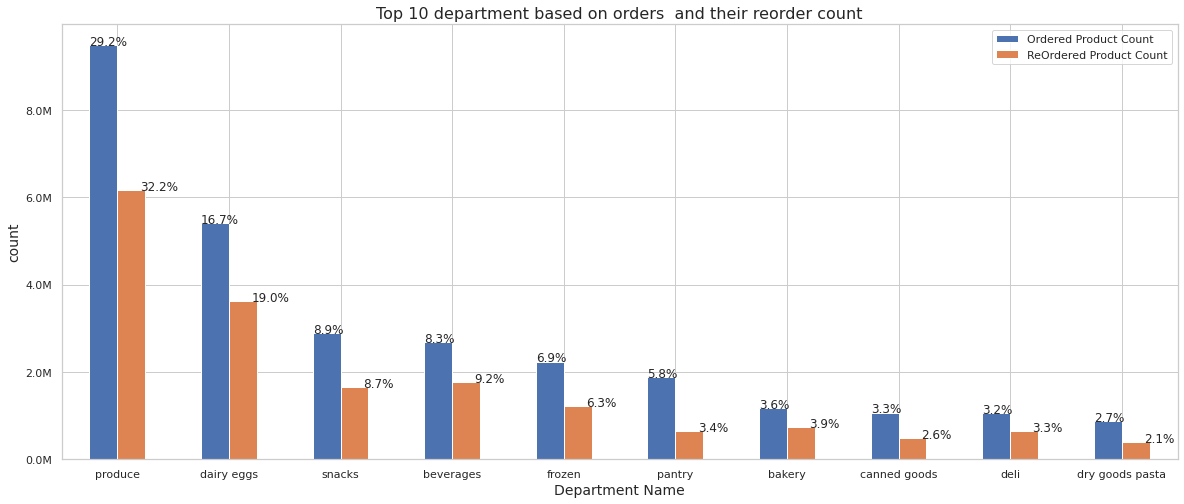

In [ ]:
department = df_prior_final['department'].value_counts()
department_df =  department.to_frame().reset_index().rename(columns={'index':'Department Name','department':'Ordered Product Count'})
department_df['% Ordered Product Count'] = np.round(( department_df['Ordered Product Count']/sum( department_df['Ordered Product Count'])).values,3)*100
reordered_department = df_prior_final[df_prior_final['reordered']==1]['department'].value_counts()
reordered_department_df =  reordered_department.to_frame().reset_index().rename(columns={'index':'Department Name','department':'ReOrdered Product Count'})
department_df = pd.merge(department_df,reordered_department_df,on='Department Name')
department_df['% ReOrdered Product Count'] = np.round(( department_df['ReOrdered Product Count']/sum( department_df['ReOrdered Product Count'])).values,3)*100
department_product_df = df_products_aisle_dep['department'].value_counts().reset_index().rename(columns={'index':'Department Name','department':'Product Count'})
department_df = pd.merge(department_df,department_product_df,on='Department Name')
department_df['% Product Count'] = np.round(( department_df['Product Count']/sum( department_df['Product Count'])).values,3)*100
print(tabulate( department_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
ax = department_df.head(10).plot(x= 'Department Name',y=['Ordered Product Count','ReOrdered Product Count'],kind='bar',figsize=(20,8),rot=0)
plt.title("Top 10 department based on orders  and their reorder count",size=16)
plt.xlabel('Department Name',size=14)
plt.ylabel('count',size=14)
total_order = sum(department_df['Ordered Product Count'])
total_reorder = sum(department_df['ReOrdered Product Count'])
total_product = sum(department_df['Product Count'])
for p in ax.patches[:10]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_order),(p.get_x(),p.get_height()+8))
for p in ax.patches[10:20]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_reorder),(p.get_x()+0.2,p.get_height()+5))
# for p in ax.patches[20:]:
#   ax.annotate('{:.1f}%'.format(100*p.get_height()/total_product),(p.get_x()+0.2,p.get_height()+5))
ylabels = list(map(lambda x : '{:.1f}'.format(x/10**6) + 'M', list(ax.get_yticks())))
ax.set_yticklabels(ylabels)
plt.show() 

<b>Observation :</b> Produce department has highest order and reorder.

+-------------------------------+-------------------------+---------------------------+---------------------------+-----------------------------+-----------------+-------------------+
| aisle Name                    |   Ordered Product Count |   % Ordered Product Count |   ReOrdered Product Count |   % ReOrdered Product Count |   Product Count |   % Product Count |
|-------------------------------+-------------------------+---------------------------+---------------------------+-----------------------------+-----------------+-------------------|
| fresh fruits                  |                 3642188 |                      11.2 |                   2615469 |                        13.7 |             382 |               0.8 |
| fresh vegetables              |                 3418021 |                      10.5 |                   2032172 |                        10.6 |             569 |               1.1 |
| packaged vegetables fruits    |                 1765313 |                     

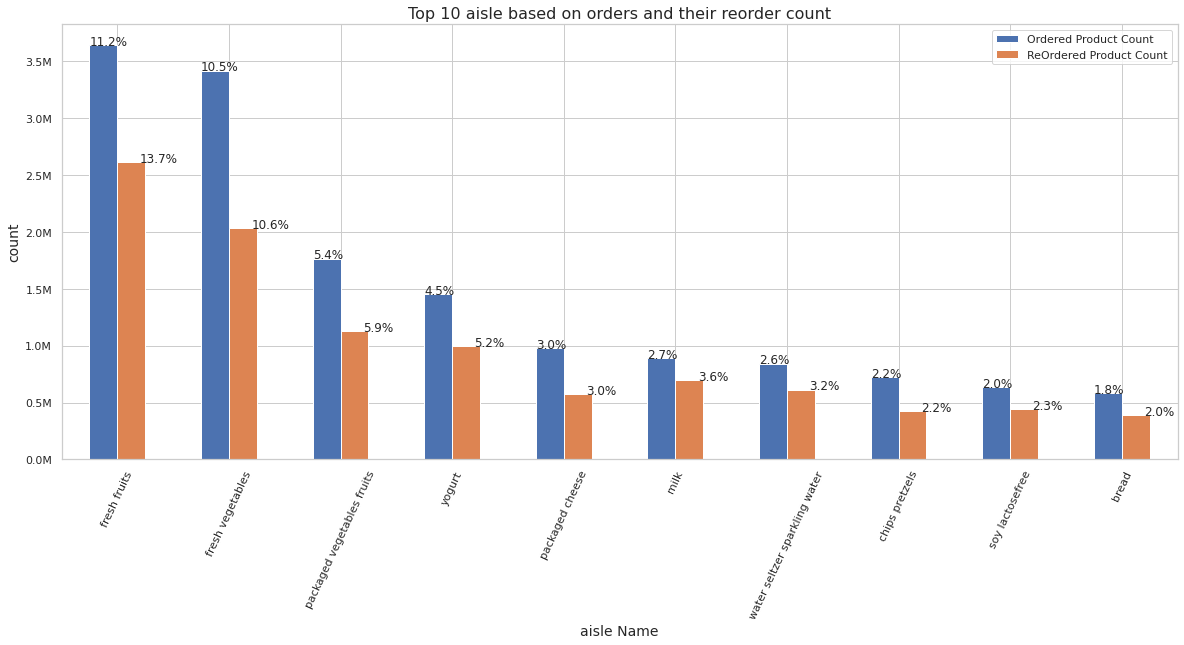

In [ ]:
aisle = df_prior_final['aisle'].value_counts()
aisle_df =  aisle.to_frame().reset_index().rename(columns={'index':'aisle Name','aisle':'Ordered Product Count'})
aisle_df['% Ordered Product Count'] = np.round(( aisle_df['Ordered Product Count']/sum( aisle_df['Ordered Product Count'])).values,3)*100
reordered_aisle = df_prior_final[df_prior_final['reordered']==1]['aisle'].value_counts()
reordered_aisle_df =  reordered_aisle.to_frame().reset_index().rename(columns={'index':'aisle Name','aisle':'ReOrdered Product Count'})
aisle_df = pd.merge(aisle_df,reordered_aisle_df,on='aisle Name')
aisle_df['% ReOrdered Product Count'] = np.round(( aisle_df['ReOrdered Product Count']/sum( aisle_df['ReOrdered Product Count'])).values,3)*100
aisle_product_df = df_products_aisle_dep['aisle'].value_counts().reset_index().rename(columns={'index':'aisle Name','aisle':'Product Count'})
aisle_df = pd.merge(aisle_df,aisle_product_df,on='aisle Name')
aisle_df['% Product Count'] = np.round(( aisle_df['Product Count']/sum( aisle_df['Product Count'])).values,3)*100
print(tabulate( aisle_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
ax = aisle_df.head(10).plot(x= 'aisle Name',y=['Ordered Product Count','ReOrdered Product Count'],kind='bar',figsize=(20,8),rot=65)
plt.title("Top 10 aisle based on orders and their reorder count",size=16)
plt.xlabel('aisle Name',size=14)
plt.ylabel('count',size=14)
total_order = sum(aisle_df['Ordered Product Count'])
total_reorder = sum(aisle_df['ReOrdered Product Count'])
total_product = sum(aisle_df['Product Count'])
for p in ax.patches[:10]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_order),(p.get_x(),p.get_height()+8))
for p in ax.patches[10:20]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_reorder),(p.get_x()+0.2,p.get_height()+5))
ylabels = list(map(lambda x : '{:.1f}'.format(x/10**6) + 'M', list(ax.get_yticks())))
ax.set_yticklabels(ylabels)
plt.show() 

<b>Observation :</b> Fresh fruit and fresh vegetables have highest order and reorders. Whic is quite natural as people buy fruits and vegetables regulat basis

In [ ]:
# Reference https://plotly.com/python/treemaps/
dep_aisle = pd.merge(aisle_df[['aisle Name','ReOrdered Product Count']],df_products_aisle_dep[['aisle',	'department']].drop_duplicates(),left_on=['aisle Name'],right_on=['aisle'])
fig = px.treemap(dep_aisle,path = ['department','aisle Name'],values ='ReOrdered Product Count',width=1400, height=700
                                                        )
fig.update_layout(title_text='Contribution of each department and aisle to Total Reorders', title_x=0.5)
fig.show()

<b>Observation :</b> In the above treemap we have shown contibution of Department and its aisle to total reorders. Produce has hisghest reorders and under produce fresh fruits and vegetables are the top aisle in terms of reorder.

# Starting Feature Engineering

We have prior data and train data seperately and prior contains 94% data.So combining both of them to get the whole set of user's purchase history

In [ ]:
# df_prior_train= df_prior_final.append(df_train_final,ignore_index = True)
# df_prior_train.to_csv('df_prior_train.csv',index=False)
# df_prior_train = pd.read_csv('df_prior_train.csv')

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,3420011,1528,12,0,177077,train,4,4,16,30.0,Sprinkles Decors,97,13,baking supplies decor,pantry
33819102,3420084,47935,20,0,9808,train,9,6,21,30.0,Classic Original Lip Balm SPF 12,73,11,facial care,personal care
33819103,3420084,9491,21,0,9808,train,9,6,21,30.0,Goats Milk & Chai Soap,25,11,soap,personal care
33819104,3420088,16380,12,0,72444,train,14,1,8,5.0,Stevia Sweetener,97,13,baking supplies decor,pantry


<font color='red'>Our objective is to predict products that will be reordered for 75K test users. So for the sake of simplicity we are ignoring the users that are not in our test data. That means we will simply train our model on the data that contains respective test users purchase history.

From the history data we are dropping users that are not in test data

In [19]:
# df_train = df_prior_train[df_prior_train.user_id.isin(df_orders[df_orders['eval_set']=='test'].user_id)]
# df_train.to_pickle ("df_train.pkl")
df_train = pd.read_pickle("df_train.pkl")

Our approach is for each userXproduct in each order we are going to look at same user's purchase behavior within a window (which is a hyperparameter) in past. to look  There will no issue of data leakage since our aim is to predict products that will be reordered in test orders and we are not given the products reordered in test data. During merging some columns such as reorderd status for each user-product in test data will become NaN since we don't know the label.<br>
<img src="Capture.PNG" width="800" height="600">

<b> Approach : </b> So our approach is for each user X product in each order we are going to look user's purchase history in a window in recent past that means for each user our window has order number which is less than current order_number in consideration. Then we calculate certain summary statistics in that particular window as a part of feature engineering.
For example let us consider the last order_id in the above pic as pointed by the arrow and window size is 1. Then we look back in time where the order number < current order number(=3). There are 2 order numbers for that user_id(=3). Since our window size is 1 we consider only latest order number which is 2 for that user_id(=3).The window is highlighted in the abobe pic.

## Encoding cyclic features

Here order_dow and order_hour_of_day are both cyclic features.
For order_dow the cycle repeats between 0 to 6 and for order_hour_of_day the cycle repeats between 0 to 23. There are certain problembs with cyclic features if we don't encode them properly. For example the difference between hour 23 and 22 is 1 but for hour 23 and 0 the difference is 23 although the real difference for both of them is 1 hour. We need to encode this cyclic features in such a way that hour 23 and 0 are close even though the absolute difference between them is 23.
<pre>One common way to encode cyclic features is to use sine an cosine transformations. 
We can do that using following transformation.
X<sub>sin</sub> = sin(2∗π∗x/max(x))
X<sub>cos</sub> = cos(2∗π∗x/max(x))
</pre>
Reference : http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [27]:
def encoding(values,max_val):
    '''
        This function returns sine and consine tranformation of 
        text(String) : input string
        Returns : 1 if  'organic' is substring of text
                  0 Otherwise
    '''
    x_sin = np.sin(2*np.pi*values/max_val)
    x_cos = np.cos(2*np.pi*values/max_val)
    return x_sin,x_cos

def get_cyclic_encoding(df):
    df['order_dow_sin'], df['order_dow_cos'] =   encoding(df['order_dow'],6) 
    # 6 is the maximum value for order_dow and 23 is the maximum value for order_dow
    df['order_hour_of_day_sin'], df['order_hour_of_day_cos'] = encoding(df['order_hour_of_day'],23)
    #df.drop(['order_dow','order_hour_of_day'],axis=1,inplace=True) # dropping original features as we don't need them
    df.sort_values(by=['user_id','order_number'], inplace=True)
    df = df.reset_index(drop=True)
    #filling NaN values with 0 since days_since_prior_order will be 0 for users ordering their first product
    df = df.fillna(0)
    return df

In [21]:
df_train = get_cyclic_encoding(df_train)

## Whether a product is Organic or not

We have Seen that people are more likely to reorder organic products. So we re adding a flag which indicates if a product is organic or not

In [22]:
def is_organic(text):
    '''
    This function whether 'organic' is substring of text or not
    Parameters:
    text(String) : input string
    Returns : 1 if  'organic' is substring of text
              0 Otherwise
    '''
    if 'organic' in str(text).lower():
        return 1
    else:
        return 0

In [7]:
#df_temp = df_train[df_train.user_id==3]
from scipy import stats

In [23]:
def get_featured_dict(df,row,window_size = 30):
    '''
        This function returns a dictionary constructed from features
        Parameters:
        df(pandas DataFrame) : Users previous purchase history
        row(pandas series) : User row that needs to be featurized
        window_size(int) : number of orders to look in past for that user to construct features
        Returns : a dictionary containing features for a user
    '''
    dict1 = {}
    dict1['order_id'] = getattr(row,'order_id')
    user_id = dict1['user_id'] = getattr(row,'user_id')
    dict1['product_id'] = getattr(row,'product_id')
    order_number = dict1['order_number'] =  getattr(row,'order_number')
    df_temp = df[(df['user_id']==user_id) & (df['order_number'] < order_number)]
    if df_temp.order_number.unique().shape[0] < 1:
        return None
    dict1['uxp_reorder_bias'] = df_temp.groupby('product_id',sort=False)['reordered'].agg('sum')\
                                                .to_frame().reordered.get(dict1['product_id'],0)
    df_temp = df_temp[df_temp['order_number'].isin(sorted(df_temp.order_number.unique(),reverse=True)[:window_size])]
    dict1['u_total_orders'] = df_temp.order_number.max()
    dict1['u_reordered_ratio'] = df_temp.reordered.mean()
    dict1['u_average_days_between_orders'] = df_temp.days_since_prior_order.mean()
    dict1['u_dow_most_orders'] = stats.mode(df_temp.order_dow.to_list())[0][0]
    dict1['u_hod_most_orders'] = stats.mode(df_temp.order_hour_of_day.to_list())[0][0]
    dict1['u_total_items_bought'] = df_temp.order_id.count()
    dict1['u_avg_basket_size'] = df_temp.groupby('order_number',sort=False)['product_id'].agg('count').mean()
    dict1['order_dow_cos'] = row.order_dow_cos
    dict1['order_dow_sin'] = row.order_dow_sin
    dict1['order_hour_of_day_sin'] = row.order_hour_of_day_sin
    dict1['order_hour_of_day_cos'] = row.order_hour_of_day_cos
    g = df_temp.groupby('product_id',sort=False)
    if row.product_id in g.groups.keys():
        g = g.get_group(row.product_id)
        g_agg = g.agg({'order_id': 'count',
                       'reordered':'mean',
                       'add_to_cart_order':'mean',
                       'days_since_prior_order':'mean'})
        dict1['uxp_total_bought'] = g_agg.order_id
        dict1['uxp_reorder_ratio'] = g_agg.reordered
        dict1['uxp_mean_add_to_cart_order'] = g_agg.add_to_cart_order
        dict1['uxp_average_days_between_orders'] = g_agg.days_since_prior_order
    else:
        dict1['uxp_total_bought'] = 0
        dict1['uxp_reorder_ratio'] = 0
        dict1['uxp_mean_add_to_cart_order'] = 0
        dict1['uxp_average_days_between_orders'] = 0
    aisle = df_temp.groupby('aisle_id',sort=False)
    if row.aisle_id in aisle.groups.keys():
        aisle  = aisle.get_group(row.aisle_id)
        dict1['uxAisle_reorder_count'] = aisle['reordered'].agg('sum')
    else:
        dict1['uxAisle_reorder_count'] = 0
    dep = df_temp.groupby('department_id',sort=False)
    if row.department_id in dep.groups.keys():
        dep  = dep.get_group(row.department_id)    
        dict1['uxDeparment_reorder_count'] = dep['reordered'].agg('sum')
    else:
        dict1['uxDeparment_reorder_count'] =0
    dict1['is_organic'] = is_organic(row.product_name) 
    try:
        dict1['reordered'] = getattr(row,'reordered')
    except:
        pass
    dict1['product_name'] = getattr(row,'product_name')
    dict1['aisle_id'] = getattr(row,'aisle_id')
    dict1['aisle'] = getattr(row,'aisle')
    dict1['department_id'] = getattr(row,'department_id')
    dict1['department'] = getattr(row,'department')
    return dict1

In [9]:
def get_featured_dict(df,row,window_size = 4):
    '''
        This function returns a dictionary constructed from features
        Parameters:
        df(pandas DataFrame) : Users previous purchase history
        row(pandas series) : User row that needs to be featurized
        window_size(int) : number of orders to look in past for that user to construct features
        Returns : a dictionary containing features for a user
    '''
    dict1 = {}
    dict1['order_id'] = getattr(row,'order_id')
    user_id = dict1['user_id'] = getattr(row,'user_id')
    dict1['product_id'] = getattr(row,'product_id')
    order_number = dict1['order_number'] =  getattr(row,'order_number')
    df_temp = df[(df['user_id']==user_id) & (df['order_number'] < order_number)]
    if df_temp.order_number.unique().shape[0] < 1:
        return None
    dict1['uxp_reorder_bias'] = df_temp.groupby('product_id',sort=False)['reordered'].agg('sum')\
                                                .to_frame().reordered.get(dict1['product_id'],0)
    df_temp = df_temp[df_temp['order_number'].isin(sorted(df_temp.order_number.unique(),reverse=True)[:window_size])]
    dict1['u_avg_basket_size'] = df_temp.groupby('order_number',sort=False)['product_id'].agg('count').mean()
    g = df_temp.groupby('product_id',sort=False)
    if row.product_id in g.groups.keys():
        g = g.get_group(row.product_id)
        g_agg = g.agg({'product_id': 'count',
                       'reordered':'mean',
                       'add_to_cart_order':'mean',
                       'days_since_prior_order':'mean',
                        'order_dow_cos':'mean',
                       'order_dow_sin':'mean',
                       'order_hour_of_day_sin':'mean',
                       'order_hour_of_day_cos':'mean'})
        dict1['uxp_order_count'] = g_agg.product_id
        dict1['uxp_reorder_ratio'] = g_agg.reordered
        dict1['uxp_mean_add_to_cart_order'] = g_agg.add_to_cart_order
        dict1['uxp_average_days_between_orders'] = g_agg.days_since_prior_order
        dict1['uxp_mean_order_dow_cos'] = g_agg.order_dow_cos
        dict1['uxp_mean_order_dow_sin'] = g_agg.order_dow_sin
        dict1['uxp_mean_order_hour_of_day_sin'] = g_agg.order_hour_of_day_sin
        dict1['uxp_mean_order_hour_of_day_cos'] = g_agg.order_hour_of_day_cos
    else:
        dict1['uxp_order_count'] = 0
        dict1['uxp_reorder_ratio'] = 0
        dict1['uxp_mean_add_to_cart_order'] = 0
        dict1['uxp_average_days_between_orders'] = 0
        dict1['uxp_mean_order_dow_cos'] = 0
        dict1['uxp_mean_order_dow_sin'] = 0
        dict1['uxp_mean_order_hour_of_day_sin'] = 0
        dict1['uxp_mean_order_hour_of_day_cos'] = 0
    aisle = df_temp.groupby('aisle_id',sort=False)
    if row.aisle_id in aisle.groups.keys():
        aisle  = aisle.get_group(row.aisle_id)
        dict1['uxAisle_reorder_count'] = aisle['reordered'].agg('sum')
    else:
        dict1['uxAisle_reorder_count'] = 0
    dep = df_temp.groupby('department_id',sort=False)
    if row.department_id in dep.groups.keys():
        dep  = dep.get_group(row.department_id)    
        dict1['uxDeparment_reorder_count'] = dep['reordered'].agg('sum')
    else:
        dict1['uxDeparment_reorder_count'] =0
    dict1['is_organic'] = is_organic(row.product_name) 
    try:
        dict1['reordered'] = getattr(row,'reordered')
    except:
        pass
    dict1['product_name'] = getattr(row,'product_name')
    dict1['aisle_id'] = getattr(row,'aisle_id')
    dict1['aisle'] = getattr(row,'aisle')
    dict1['department_id'] = getattr(row,'department_id')
    dict1['department'] = getattr(row,'department')
    return dict1

In [12]:
def feature_engineering(df_train,data,p_name,d_type,window_size = 4):
    '''
        This function generates featurized dataframe
        Parameters:
        df_train(pandas DataFrame) : Users previous purchase history
        data(pandas DataFrame) : Users that need to featurized
        d_type(string) : type of data i.e train or test
        p_name(string) : Process name 
        window_size(int) : number of orders to look in past for that user to construct features
        Returns : None
    '''
    start = datetime.now()
    rows_list = []
    i=0
    for row in data.itertuples():
        i += 1
        if i%300000 == 0:
            gc.collect()
            print("{0} rows compelte for {1} process, Time taken = {2}".format(i,p_name,datetime.now() - start))
        d = get_featured_dict(df_train,row,window_size)
        if d is not None:
            rows_list.append(d)
    df = pd.DataFrame(rows_list)
    df.to_pickle('{0}_feature_engineering_{1}.pkl'.format(d_type,p_name))

Below Diagram describes the process of feature engineering<br>Refreence : https://docs.python.org/3/library/multiprocessing.html

<img src="Feature Engineering.png" width="800" height="600">

In [12]:
users = np.array_split(np.array(sorted(df_train.user_id.unique())),8)
data = [] # this list will contain 8 different dataframes generated by splitting df_train in 4 parts
for i in range(8):
    data.append(df_train[df_train.user_id.isin(users[i])])
# sanity check to ensure users have been divided in 8 dataframes or not.If it is empty then we are going right
set(data[0].user_id.unique()).intersection(set(data[1].user_id.unique())).intersection(set(data[2].user_id.unique()))\
                                                                            .intersection(set(data[3].user_id.unique()))
del df_train # deleting as we don't need it

In [13]:
# Refreence : https://docs.python.org/3/library/multiprocessing.html
import  multiprocessing as mp
#mp.set_start_method('spawn')
jobs = []
for i in range(0,8):
    p = mp.Process(target=feature_engineering,args = (data[i],data[i],'P_{0}'.format(i+1),'train',100,))
    jobs.append(p)
    p.start()
for p in jobs:  
    p.join()
print('Done')

300000 rows compelte for P_1 process, Time taken = 1:28:08.679291
300000 rows compelte for P_4 process, Time taken = 1:28:27.550705
300000 rows compelte for P_2 process, Time taken = 1:28:53.140628
300000 rows compelte for P_5 process, Time taken = 1:29:28.100105
300000 rows compelte for P_7 process, Time taken = 1:31:02.691794
300000 rows compelte for P_6 process, Time taken = 1:32:16.001659
300000 rows compelte for P_3 process, Time taken = 1:32:19.989563
300000 rows compelte for P_8 process, Time taken = 1:36:02.230368
600000 rows compelte for P_1 process, Time taken = 2:57:17.540294
600000 rows compelte for P_5 process, Time taken = 2:58:57.531926
600000 rows compelte for P_4 process, Time taken = 2:59:24.192485
600000 rows compelte for P_2 process, Time taken = 3:00:09.397294
600000 rows compelte for P_7 process, Time taken = 3:00:38.383556
600000 rows compelte for P_3 process, Time taken = 3:01:04.065228
600000 rows compelte for P_8 process, Time taken = 3:09:31.886665
600000 row

Merging all the small dataframes created by each process

In [14]:
df = pd.DataFrame()
for i in range(1,9):
    df_temp = pd.read_pickle('train_feature_engineering_P_{0}.pkl'.format(i))
    df = df.append(df_temp,ignore_index = True)
df.to_pickle("train_data_window_100.pkl")

In [ ]:
df_train =  pd.read_pickle("train_data_window_14.pkl")
df_train

,order_id,user_id,product_id,order_number,uxp_reorder_bias,u_avg_basket_size,uxp_order_count,uxp_reorder_ratio,uxp_mean_add_to_cart_order,uxp_average_days_between_orders,uxp_mean_order_dow_cos,uxp_mean_order_dow_sin,uxp_mean_order_hour_of_day_sin,uxp_mean_order_hour_of_day_cos,uxAisle_reorder_count,uxDeparment_reorder_count,is_organic,reordered,product_name,aisle_id,aisle,department_id,department
0,444309,3,38596,2,0,10.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,Part Skim Ricotta Cheese,108,other creams cheeses,16,dairy eggs
1,444309,3,21903,2,0,10.000000,1.0,0.0,7.0,0.0,0.5,0.866025,-0.631088,-0.775711,0,0,1,1,Organic Baby Spinach,123,packaged vegetables fruits,4,produce
2,444309,3,248,2,0,10.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,Dried Sweetened Cranberries,117,nuts seeds dried fruit,19,snacks
3,444309,3,40604,2,0,10.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,Feta Cheese Crumbles,21,packaged cheese,16,dairy eggs
4,444309,3,8021,2,0,10.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,100% Recycled Paper Towels,54,paper goods,17,household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11036777,1882108,206208,2643,49,5,12.714286,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,7,28,1,1,Organic Bagged Kale Salad Mix,123,packaged vegetables fruits,4,produce
11036778,1882108,206208,21405,49,0,12.714286,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,7,28,1,0,"Organic Red Radish, Bunch",83,fresh vegetables,4,produce
11036779,1882108,206208,7632,49,0,12.714286,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,Old Style Whole Grain Dijon Mustard,72,condiments,13,pantry
11036780,1882108,206208,1942,49,0,12.714286,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,Aged White Wine Vinegar,19,oils vinegars,13,pantry


In [15]:
import os
for i in range(1,9):
    os.remove('train_feature_engineering_P_{0}.pkl'.format(i)) 

#### Now for test data we are taking all historical products each user has ordered in out featurized trained data and combined with given test orders so that we can predict which products a user is likely to order in his next order

In [24]:
# test= df_train[['user_id','product_id','product_name','aisle_id','department_id','aisle','department']].drop_duplicates()
# test = pd.merge(test,df_orders[df_orders['eval_set']=='test'],on='user_id')
# test.to_pickle('df_test.pkl')
df_test = pd.read_pickle('df_test.pkl')

In [28]:
df_test = get_cyclic_encoding(df_test)

In [ ]:
df_test.user_id.unique().shape
# So all the 75000 test users are unique in test data

(11792498, 17)

In [25]:
df_test

,user_id,product_id,product_name,aisle_id,department_id,aisle,department,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,3,38596,Part Skim Ricotta Cheese,108,16,other creams cheeses,dairy eggs,2774568,test,13,5,15,11.0
1,3,21903,Organic Baby Spinach,123,4,packaged vegetables fruits,produce,2774568,test,13,5,15,11.0
2,3,248,Dried Sweetened Cranberries,117,19,nuts seeds dried fruit,snacks,2774568,test,13,5,15,11.0
3,3,40604,Feta Cheese Crumbles,21,16,packaged cheese,dairy eggs,2774568,test,13,5,15,11.0
4,3,8021,100% Recycled Paper Towels,54,17,paper goods,household,2774568,test,13,5,15,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4517436,206208,18880,Organic Free Range Low Sodium Chicken Broth,69,15,soup broth bouillon,canned goods,803273,test,50,5,11,4.0
4517437,206208,34282,Original Sandwich Bread,58,1,frozen breads doughs,frozen,803273,test,50,5,11,4.0
4517438,206208,21405,"Organic Red Radish, Bunch",83,4,fresh vegetables,produce,803273,test,50,5,11,4.0
4517439,206208,7632,Old Style Whole Grain Dijon Mustard,72,13,condiments,pantry,803273,test,50,5,11,4.0


#### Feature engineering for test data

In [29]:
users = np.array_split(np.array(sorted(df_test.user_id.unique())),8)
train_data = [] # this list will contain 8 different dataframes generated by splitting df_train in 4 parts
test_data = [] # this list will contain 8 different dataframes generated by splitting df_test in 4 parts
for i in range(8):
    train_data.append(df_train[df_train.user_id.isin(users[i])])
    test_data.append(df_test[df_test.user_id.isin(users[i])])
del df_train # deleting as we don't need it
del df_test

In [ ]:
# Refreence : https://docs.python.org/3/library/multiprocessing.html
import  multiprocessing as mp
#mp.set_start_method('spawn')
jobs = []
for i in range(0,8):
    p = mp.Process(target=feature_engineering,args = (train_data[i],test_data[i],'P_{0}'.format(i+1),'test',100,))
    jobs.append(p)
    p.start()
for p in jobs:  
    p.join()
print('Done')

300000 rows compelte for P_3 process, Time taken = 1:58:24.486101
300000 rows compelte for P_5 process, Time taken = 1:58:41.414661
300000 rows compelte for P_6 process, Time taken = 1:59:56.264265
300000 rows compelte for P_7 process, Time taken = 2:01:06.713640
300000 rows compelte for P_4 process, Time taken = 2:01:43.082348
300000 rows compelte for P_8 process, Time taken = 2:01:54.628874
300000 rows compelte for P_2 process, Time taken = 2:02:44.218054
300000 rows compelte for P_1 process, Time taken = 2:04:01.833902


In [ ]:
df = pd.DataFrame()
for i in range(1,9):
    df_temp = pd.read_pickle('test_feature_engineering_P_{0}.pkl'.format(i))
    df = df.append(df_temp,ignore_index = True)
df.to_pickle("test_data_window_100.pkl")

In [18]:
# Detelting intermediate files genearted by each process
import os
for i in range(1,9):
    os.remove('test_feature_engineering_P_{0}.pkl'.format(i)) 

# Modeling

In [12]:
# we have tried different window sizes like 3,4,7,14,21,30 observed that window size 30
#works reasonlably well
train_data = pd.read_pickle("train_data_window_30.pkl")
test_data = pd.read_pickle("test_data_window_30.pkl")

In [21]:
def memory_usage(df):
    return (round(df.memory_usage(deep=True).sum()/1024**2,2))
print("Memory usage by full train Dataframe is {}".format(memory_usage(train_data)))
print("Memory usage by full test Dataframe is {}".format(memory_usage(test_data)))
# We are going to optimize the data usage by dataframe  

Memory usage by full train Dataframe is 3984.61
Memory usage by full test Dataframe is 1600.09


We will try to reduce the memory usage of the train dataframe <br>
Reference : https://towardsdatascience.com/make-working-with-large-dataframes-easier-at-least-for-your-memory-6f52b5f4b5c4

In [13]:
# column_dtypes = {'order_id' : np.uint32,
#                  'user_id' : np.uint32,
#                 'product_id' : np.uint16,
#                  'order_number' : np.uint8,
#                  'uxp_reorder_bias' : np.uint8,
#                  'u_avg_basket_size' :  np.float16,
#                  'uxp_order_count'  :   float,
#                  'uxp_reorder_ratio' :  float,
#                 'uxp_mean_add_to_cart_order' : float,
#                 'uxp_average_days_between_orders' : float,
#                 'uxp_mean_order_dow_cos' : float,
#                 'uxp_mean_order_dow_sin' : float,
#                 'uxp_mean_order_hour_of_day_sin' : float,
#                 'uxp_mean_order_hour_of_day_cos' : float,
#                  'uxAisle_reorder_count' : np.uint16,
#                  'uxDeparment_reorder_count' : np.uint16,
#                  'is_organic' : np.uint8 ,
#                  'reordered' : np.uint8,
#                  'aisle_id' : np.uint8,
#                  'department_id' : np.uint8,
#                  'aisle' : 'category',
#                  'department' : 'category',
#                  'product_name' : 'category'
#                 }
column_dtypes = {
                'order_id' : np.uint32,
                 'uxp_total_bought' : np.uint8,
                 'uxp_reorder_ratio' :  np.float32,
                 'uxp_avg_cart_position': np.float32,
                 'uxp_bought_last5'  :   np.float16,
                 'u_total_orders' : np.uint8,
                 'u_reordered_ratio' : np.float32,
                 'u_average_days_between_orders' : np.float16,
                 'u_days_between_orders_std' : np.float32,
                 'u_dow_most_orders' : np.uint8,
                 'u_hod_most_orders' : np.uint8,
                 'u_total_items_bought' : np.uint32,
                 'u_avg_basket_size' : np.float16,
                 'p_total_purchases' : np.uint32,
                 'p_reorder_ratio' : np.float16,
                 'p_avg_cart_position' : np.float32,
                 'reordered' : np.uint8,
                 'order_dow_cos' : float,
                 'order_dow_sin' : float,
                'order_hour_of_day_sin' : float,
                'order_hour_of_day_cos' : float,
                 'is_organic' : np.uint8,
                 'product_name' : str,
                 'u_dow_most_orders' : np.uint8,
                 'u_hod_most_orders' :  np.uint8,
                 'u_total_unique_prod' :  np.uint16,
                 'u_basket_sum' :  np.uint32,
                 'u_basket_std' : np.float32,
                 'p_avg_cart_position': np.float32,
                 'p_unique_user_count' : np.uint32,
                'order_id' : np.uint32,
                 'user_id' : np.uint32,
                'product_id' : np.uint16,
                 'order_number' : np.uint8,
                 'uxp_reorder_bias' : np.uint8,
                 'u_avg_basket_size' :  np.float16,
                 'uxp_order_count'  :   float,
                 'uxp_reorder_ratio' :  float,
                'uxp_mean_add_to_cart_order' : float,
                'uxp_average_days_between_orders' : float,
                'uxp_mean_order_dow_cos' : float,
                'uxp_mean_order_dow_sin' : float,
                'uxp_mean_order_hour_of_day_sin' : float,
                'uxp_mean_order_hour_of_day_cos' : float,
                 'uxAisle_reorder_count' : np.uint16,
                 'uxDeparment_reorder_count' : np.uint16,
                 'is_organic' : np.uint8 ,
                 'reordered' : np.uint8,
                 'aisle_id' : np.uint8,
                 'department_id' : np.uint8,
                 'aisle' : 'category',
                 'department' : 'category',
                 'product_name' : 'category'
                }

for col in train_data.columns:
    train_data[col] = train_data[col].astype(column_dtypes[col])
for col in test_data.columns:
    test_data[col] = test_data[col].astype(column_dtypes[col])

In [23]:
print("Memory usage by optimized train Dataframe is {}".format(memory_usage(train_data)))
print("Memory usage by optimized train Dataframe is {}".format(memory_usage(test_data)))
# So there is a clear reduction of around 75% in memory usage of DataFrame

Memory usage by optimized train Dataframe is 984.2
Memory usage by optimized train Dataframe is 401.68


In [14]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    

In [15]:
train_data = train_data.set_index(['user_id','product_id','order_id'])
test_data = test_data.set_index(['user_id','product_id','order_id'])

In [11]:
# X_train,y_train = train_data.drop(['reordered','product_name','aisle','department'],axis=1), train_data.reordered
# X_test = test_data.drop(['product_name','aisle','department'],axis=1)
# del train_data,test_data
# gc.collect()
data_y = train_data['reordered']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_cv, y_train, y_cv = train_test_split(train_data.drop(['order_number','uxAisle_reorder_count','uxDeparment_reorder_count','aisle_id','department_id','reordered','product_name','aisle','department'],axis=1), data_y,stratify=data_y,test_size=0.20)
X_test = test_data.drop(['order_number','uxAisle_reorder_count','uxDeparment_reorder_count','aisle_id','department_id','product_name','aisle','department'],axis=1)

In [16]:

data_y = train_data['reordered']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_cv, y_train, y_cv = train_test_split(train_data.drop(['order_number','reordered','product_name','aisle','department'],axis=1), data_y,stratify=data_y,test_size=0.20)
X_test = test_data.drop(['order_number','product_name','aisle','department'],axis=1)

In [9]:
X_train

,,,uxp_reorder_bias,u_total_orders,u_reordered_ratio,u_average_days_between_orders,u_dow_most_orders,u_hod_most_orders,u_total_items_bought,u_avg_basket_size,order_dow_cos,order_dow_sin,order_hour_of_day_sin,order_hour_of_day_cos,uxp_total_bought,uxp_reorder_ratio,uxp_mean_add_to_cart_order,uxp_average_days_between_orders,uxAisle_reorder_count,uxDeparment_reorder_count,is_organic,aisle_id,department_id
user_id,product_id,order_id,,,,,,,,,,,,,,,,,,,,,
19862,5785,1702468,0,15,0.546512,12.328125,0,17,86,5.734375,-0.5,8.660254e-01,-0.997669,-0.068242,0,0.000000,0.0,0.000000,0,10,1,84,16
138078,24852,1978653,4,7,0.475410,5.656250,4,16,61,8.710938,1.0,-2.449294e-16,-0.398401,-0.917211,5,0.800000,4.4,4.600000,4,6,0,24,4
33771,9839,2257425,1,4,0.380952,9.554688,2,13,63,15.750000,1.0,0.000000e+00,-0.269797,0.962917,2,0.500000,7.0,10.000000,3,11,1,83,4
68532,39032,2154346,0,22,0.478261,9.562500,5,7,184,8.367188,1.0,0.000000e+00,0.942261,-0.334880,0,0.000000,0.0,0.000000,0,16,0,123,4
81358,45586,825715,2,38,0.640853,7.343750,0,15,891,23.453125,-0.5,8.660254e-01,-0.398401,-0.917211,3,0.666667,24.0,6.000000,4,17,0,75,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,30489,1986344,10,74,0.860966,3.912109,2,13,1532,20.703125,-0.5,-8.660254e-01,-0.398401,-0.917211,11,0.909091,17.0,4.454545,10,42,0,67,20
56035,41534,1778903,0,5,0.251852,5.828125,3,13,135,27.000000,1.0,-2.449294e-16,0.942261,-0.334880,1,0.000000,17.0,0.000000,2,14,0,123,4
199669,9825,2299295,0,2,0.023810,4.714844,3,19,42,21.000000,0.5,-8.660254e-01,-0.887885,0.460065,0,0.000000,0.0,0.000000,0,0,1,52,1


# LGBM

In [8]:
# Reference : https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
import warnings
warnings.filterwarnings('ignore')
estimator  = lgb.LGBMClassifier()
# Hyperparameter grid
parameters = {
    'class_weight': [None, 'balanced'],
    'early_stopping_round' : [50,100],
    'boosting_type': ['gbdt','dart','goss'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}
# Subsampling (only applicable with 'goss')
# subsample_dist = list(np.linspace(0.5, 1, 100))
random_search = RandomizedSearchCV(estimator,param_distributions=parameters,scoring = 'neg_log_loss',
                                   n_jobs = 6, cv = 3,
                            verbose=True,n_iter=50,random_state=25) #neg_log_loss f1
random_search.fit(X_train,y_train)
random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed: 29.8min finished


LGBMClassifier(boosting_type='dart', early_stopping_round=50,
               learning_rate=0.16938117107675146, min_child_samples=95,
               num_leaves=39, reg_alpha=0.3469387755102041,
               reg_lambda=0.42857142857142855, subsample_for_bin=240000)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnin

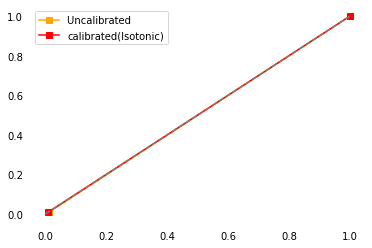

In [9]:
clf = lgb.LGBMClassifier(boosting_type='dart', early_stopping_round=50,
               learning_rate=0.16938117107675146, min_child_samples=95,
               num_leaves=39, reg_alpha=0.3469387755102041,
               reg_lambda=0.42857142857142855, subsample_for_bin=240000, n_jobs=- 1)
clf.fit(X_train,y_train)
predict_y = clf.predict_proba(X_train)[:,1]
iso_clf = CalibratedClassifierCV(clf, method="isotonic")
iso_clf.fit(X_train, y_train)
predict_y2 = iso_clf.predict_proba(X_train)[:,1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_train, predict_y, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-',  color='orange',label='Uncalibrated ')
fraction_of_positives, mean_predicted_value = calibration_curve(y_train, predict_y2, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-',  color='red',label='calibrated(Isotonic)')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().legend()
plt.show()

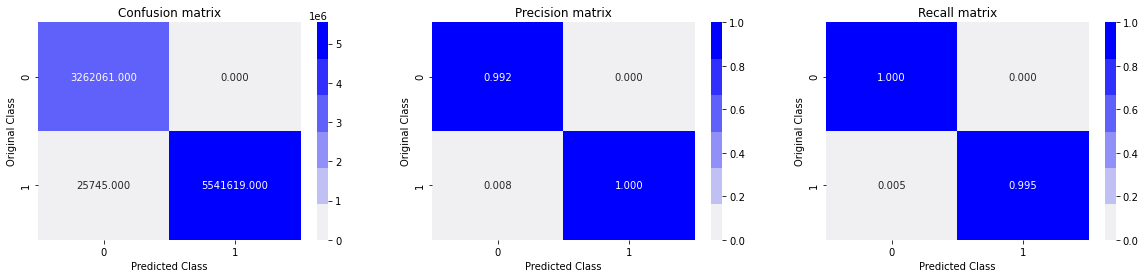

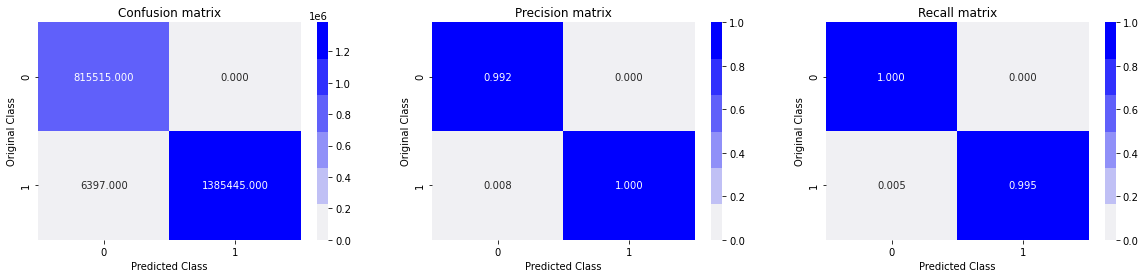

In [20]:
clf = lgb.LGBMClassifier(objective='binary' ,boosting_type='gbdt',
               learning_rate=0.16938117107675146, min_child_samples=95,
               num_leaves=39, reg_alpha=0.3469387755102041,
               reg_lambda=0.42857142857142855, subsample_for_bin=240000, n_jobs=- 1)
clf.fit(X_train,y_train)
plot_confusion_matrix(y_train,clf.predict(X_train))
plot_confusion_matrix(y_cv,clf.predict(X_cv))


In [15]:
p = clf.predict_proba(X_cv)[:, 1]

In [16]:
print(p.shape)
print(p[p>0.5].shape)
p[p>0.03].shape

(2207357,)
(1391842,)


(1391842,)

In [60]:
y_cv.value_counts()

1    1391842
0     815515
Name: reordered, dtype: int64

In [8]:
plot_confusion_matrix(y_train,iso_clf.predict(X_train))
plot_confusion_matrix(y_cv,iso_clf.predict(X_cv))

NameError: name 'iso_clf' is not defined

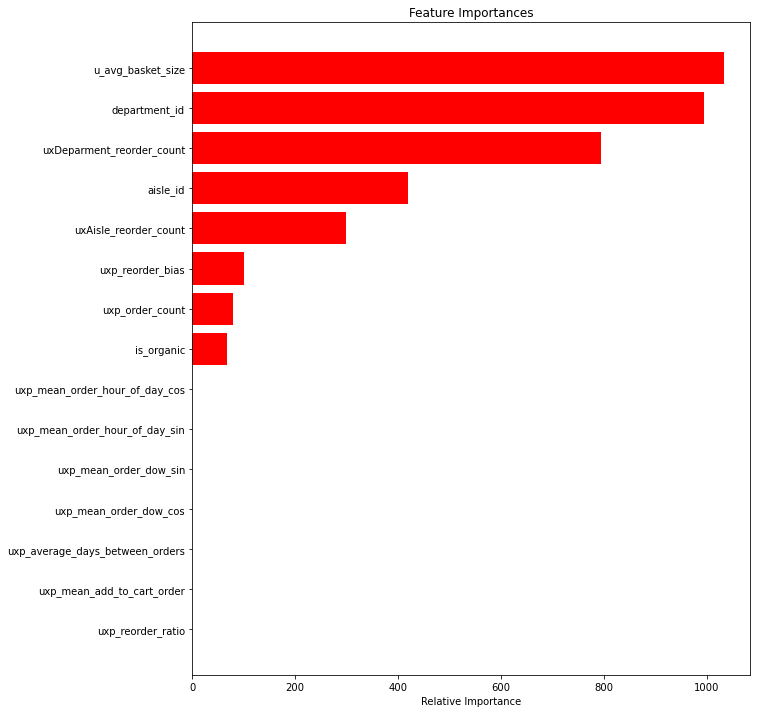

In [21]:
features = X_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [12]:
train_pred_y= iso_clf.predict(X_train)
test_pred_y= iso_clf.predict(X_test)

In [13]:
train_pred_y1= iso_clf.predict_proba(X_train)[:,1]
test_pred_y1= iso_clf.predict_proba(X_test)[:,1]
X_train['pred_prob'] =  train_pred_y1
X_test['pred_prob'] =  test_pred_y1
X_train['pred_val'] =  train_pred_y
X_test['pred_val'] =  test_pred_y
X_test = X_test.reset_index()

In [51]:
predictions = X_test[['user_id','product_id','pred_val']]

In [ ]:
predictions = predictions.merge(test_data[['user_id','order_id']],on='user_id')

In [ ]:
predictions

In [38]:
import joblib
# save model
joblib.dump(clf, 'lgb.pkl')
# load model
clf = joblib.load('lgb.pkl')

In [14]:
def get_predictions(df):
    d ={} # dict keys are order_id and values are products predicted
    i=0
    for row in df.itertuples():
        i +=1
        if i%1000000==0:
            print("{0} rows completed".format(i))
        if row.pred_val == 1:
            try:
                d[row.order_id] += ' ' + str(row.product_id)
            except:
                 d[row.order_id] = str(row.product_id)
    # If there is no product predicted for a order_id then we are predicting None for that order_id
    for order in df.order_id.unique():
        if order not in d.keys():
            d[order] = None
    sub = pd.DataFrame.from_dict(d, orient='index')
    sub.reset_index(inplace=True)
    sub.columns = ['order_id', 'products']
    return sub

In [15]:
#train_pred = get_predictions(X_train)
test_pred = get_predictions(X_test)
test_pred

1000000 rows completed
2000000 rows completed
3000000 rows completed
4000000 rows completed


,order_id,products
0,2774568,38596 21903 248 40604 8021 17668 21137 23650 3...
1,329954,42329 7160 1200 17769 43704 37646 11865 35469 ...
2,1528013,38293 20323 40992 21903 45007 11068 10644 4940...
3,1376945,47601 18465 35640 35948 8670 14947 42585 41290...
4,1356845,13176 10863 17766 7076 28134 46157 20350 48835...
...,...,...
74995,2728930,26620 432 24852 45535 43122 24830 14678 45264 ...
74996,350108,43961 21137 30561 42828 5646 5785 12240 17794 ...
74997,1043943,38530 47011 27086 11520 49235 28309 41387 2373...
74998,2821651,11140 45965 19678 44632 32869 45578 3397 34530...


In [16]:
test_pred.to_csv("submission.csv", index=False, header=True)

In [44]:
X_train = X_train.drop(['pred_val'],axis=1)
X_test = X_test.drop(['pred_val'],axis=1)